In [9]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/ubuntu/varios/skforecast'

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDiff import ForecasterAutoregDiff
from skforecast.ForecasterAutoregDiff_2 import ForecasterAutoregDiff_2
from sklearn.linear_model import Ridge

In [89]:
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
y = data['y']
y = y.sort_index()
exog  = pd.DataFrame(np.random.randn(len(y), 3), columns=['exog_1', 'exog_2', 'exog_3'], index=y.index)

# Data partition train-test
# ==============================================================================
end_train = '2005-06-01 23:59:00'
print(
    f"Train dates : {y.index.min()} --- {y.loc[:end_train].index.max()}  " 
    f"(n={len(y.loc[:end_train])})")
print(
    f"Test dates  : {y.loc[end_train:].index.min()} --- {y.index.max()}  "
    f"(n={len(y.loc[end_train:])})")


y_train = y.loc[:end_train]
y_test  = y.loc[end_train:]

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [83]:
forecaster = ForecasterAutoregDiff(
    regressor = "ridge",
    lags = 3,
    differentiation = None,
)

X_train, y_train = forecaster.create_train_X_y(y=y, exog=exog)
display(X_train.head(3))
display(y_train.head(3))    

,lag_1,lag_2,lag_3,exog_1,exog_2,exog_3
datetime,,,,,,
1991-10-01,0.432159,0.400906,0.429795,-0.476931,1.503561,-1.367168
1991-11-01,0.492543,0.432159,0.400906,0.067393,0.485178,1.287127
1991-12-01,0.502369,0.492543,0.432159,-1.526428,-3.064141,0.115370


datetime
1991-10-01    0.492543
1991-11-01    0.502369
1991-12-01    0.602652
Freq: MS, Name: y, dtype: float64

In [84]:
forecaster = ForecasterAutoregDiff(
    regressor = Ridge(),
    lags = 3,
    differentiation = 1,
)

X_train, y_train = forecaster.create_train_X_y(y=y, exog=exog)
display(X_train.head(10))
display(y_train.head(10))    

,lag_1,lag_2,lag_3,exog_1,exog_2,exog_3
datetime,,,,,,
1991-11-01,0.060384,0.031253,-0.028889,0.067393,0.485178,1.287127
1991-12-01,0.009826,0.060384,0.031253,-1.526428,-3.064141,0.115370
1992-01-01,0.100283,0.009826,0.060384,0.317427,0.173680,-0.877247
1992-02-01,0.057467,0.100283,0.009826,-0.044161,-1.540079,0.420593
1992-03-01,-0.323899,0.057467,0.100283,0.892588,-0.732032,-2.003942
1992-04-01,0.015128,-0.323899,0.057467,-0.129782,-0.198500,-0.080607
1992-05-01,0.028460,0.015128,-0.323899,1.303575,0.138595,2.084123
1992-06-01,-0.018007,0.028460,0.015128,0.380743,-1.087234,1.133613
1992-07-01,0.048733,-0.018007,0.028460,-0.090344,-0.488771,0.279401


datetime
1991-11-01    0.009826
1991-12-01    0.100283
1992-01-01    0.057467
1992-02-01   -0.323899
1992-03-01    0.015128
1992-04-01    0.028460
1992-05-01   -0.018007
1992-06-01    0.048733
1992-07-01    0.072855
1992-08-01   -0.007925
Freq: MS, Name: y, dtype: float64

<Axes: xlabel='datetime'>

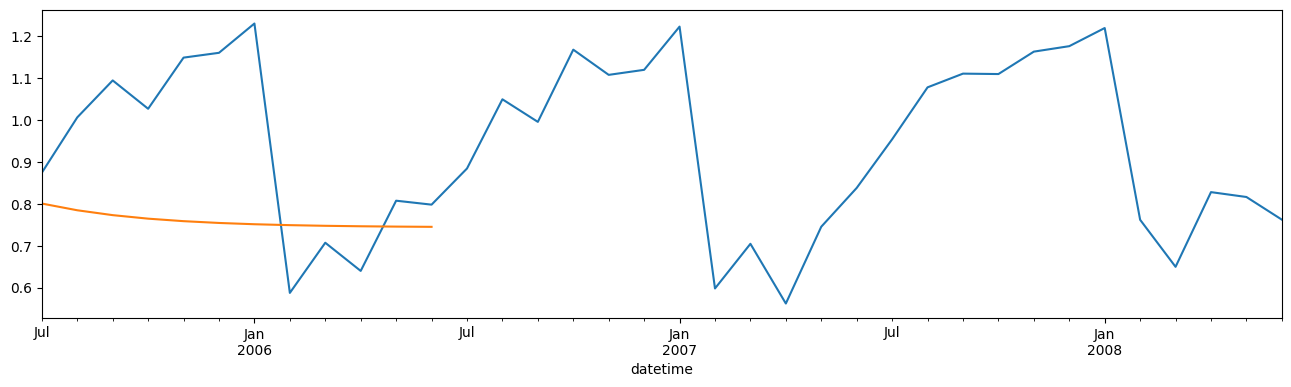

In [90]:
forecaster = ForecasterAutoreg(
    regressor = Ridge(),
    lags = 3,
)
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=12)
fig, axis = plt.subplots(figsize=(16, 4))
y_test.plot(ax=axis, label='y_test')
predictions.plot(ax=axis, label='predictions')

datetime
2005-07-01    0.874336
2005-08-01    1.006497
2005-09-01    1.094736
2005-10-01    1.027043
2005-11-01    1.149232
2005-12-01    1.160712
2006-01-01    1.230691
2006-02-01    0.587135
2006-03-01    0.706959
2006-04-01    0.639641
2006-05-01    0.807405
2006-06-01    0.797970
2006-07-01    0.884312
2006-08-01    1.049648
2006-09-01    0.995709
2006-10-01    1.168253
2006-11-01    1.108038
2006-12-01    1.120053
2007-01-01    1.223319
2007-02-01    0.597753
2007-03-01    0.704398
2007-04-01    0.561760
2007-05-01    0.745258
2007-06-01    0.837934
2007-07-01    0.954144
2007-08-01    1.078219
2007-09-01    1.110982
2007-10-01    1.109979
2007-11-01    1.163534
2007-12-01    1.176589
2008-01-01    1.219941
2008-02-01    0.761822
2008-03-01    0.649435
2008-04-01    0.827887
2008-05-01    0.816255
2008-06-01    0.762137
Freq: MS, Name: y, dtype: float64

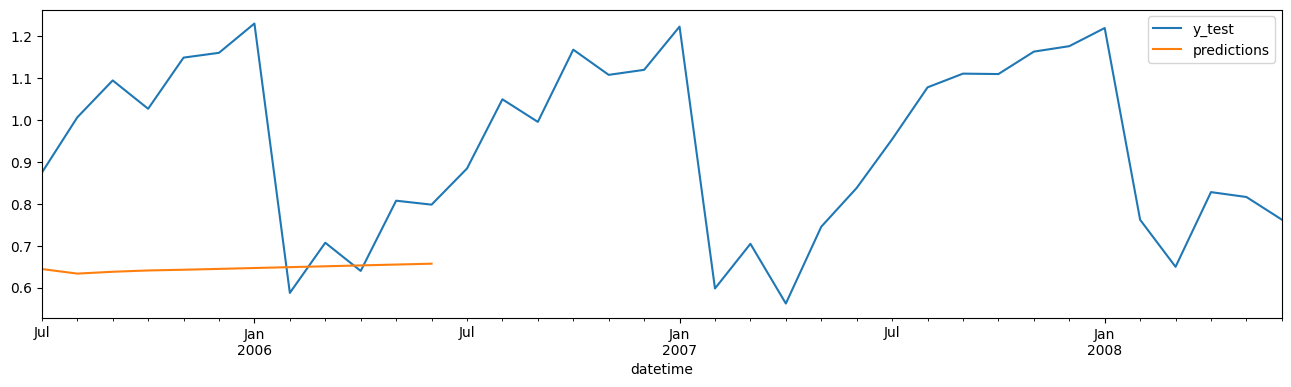

In [94]:
forecaster = ForecasterAutoregDiff(
    regressor = Ridge(),
    lags = 3,
    differentiation = 1,
)
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=12)
fig, axis = plt.subplots(figsize=(16, 4))
y_test.plot(ax=axis, label='y_test')
predictions.plot(ax=axis, label='predictions')
axis.legend();
y_test

<Axes: xlabel='datetime'>

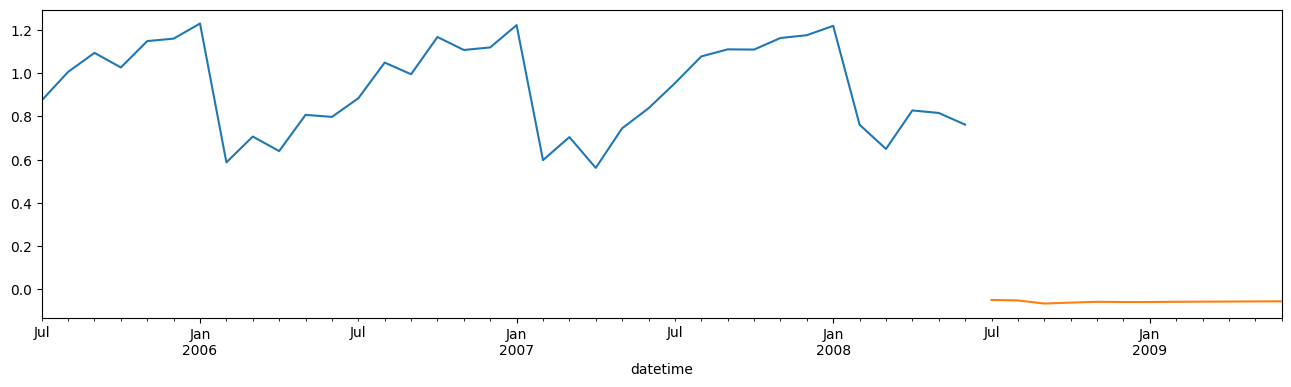

In [88]:
forecaster = ForecasterAutoregDiff_2(
    regressor = Ridge(),
    lags = 3,
    differentiation = 1,
)
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=12)
fig, axis = plt.subplots(figsize=(16, 4))
y_test.plot(ax=axis, label='y_test')
predictions.plot(ax=axis, label='predictions')

In [7]:
forecaster = ForecasterAutoregDiff(
    regressor = Ridge(),
    lags = 3,
    differentiation = None
)
forecaster.fit(y=y)
forecaster.predict(steps=5)

2000-04-10    0.034849
2000-04-11    0.227546
2000-04-12   -0.099882
2000-04-13    0.070084
2000-04-14    0.015421
Freq: D, Name: pred, dtype: float64

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class TimeSeriesDifferentiator(BaseEstimator, TransformerMixin):
    """
    Transforms a time series into a differentiated time series of order n.
    It also reverts the differentiation.

    Parameters
    ----------
    order : int
        Order of differentiation.

    Attributes
    ----------
    initial_values : list
        List with the initial value the time series after each differentiation.
        This is used to revert the differentiation.
    order : int
        Order of differentiation.   

    """
    
    def __init__(self, order=1):
        self.order = order
        self.initial_values = []
    
    def fit(self, X, y=None):
        """
        Fits the transformer. This method does nothing.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Time series to be differentiated.
        y : None
            Ignored.

        Returns
        -------
        self : object
        """
        self.initial_values = []
        return self
    

    def transform(self, X, y=None):
        """
        Transforms a time series into a differentiated time series of order n.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Time series to be differentiated.
        y : None
            Ignored.
        
        Returns
        -------
        X_diff : array-like of shape (n_samples,)
            Differentiated time series.

        """
        for i in range(self.order):
            if i == 0:
                self.initial_values.append(X[0])
                X_diff = np.diff(X, n=1, prepend=np.nan)
            else:
                self.initial_values.append(X_diff[0])
                X_diff = np.diff(X, n=1, prepend=np.nan)
        return X_diff
    
    
    def inverse_transform(self, X, y=None):
        """
        Reverts the differentiation.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Differentiated time series.
        y : None
            Ignored.
        
        Returns
        -------
        X_diff : array-like of shape (n_samples,)
            Reverted differentiated time series.

        """
        # Remove initial nan values if present
        X = X[np.argmax(~np.isnan(X)):]
        for i in range(self.order):
            if i == 0:
                X_diff = np.insert(X, 0, self.initial_values[self.order-1])
                X_diff = np.cumsum(X_diff)
            else:
                X_diff = np.insert(X_diff, 0, self.initial_values[self.order-i-1])
                X_diff = np.cumsum(X_diff)
        return X_diff



# Generate a sample time series
X = np.arange(10)

# Differentiate the time series up to order 1
differentiator = TimeSeriesDifferentiator(order=1)
differentiator.fit(X)
X_diff = differentiator.transform(X)



# Revert the differentiation
X_reverted = differentiator.inverse_transform(X_diff)

# Print the original time series, the differentiated time series, and the reverted time series
print(f"Original time series: {X}")
print(f"Differentiated time series: {X_diff}")
print(f"Reverted time series: {X_reverted}")

Original time series: [0 1 2 3 4 5 6 7 8 9]
Differentiated time series: [nan  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Reverted time series: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [37]:
differentiator.fit_transform(X)

array([nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])